# Segmentation for Brain MRI

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Import Packages

In [ ]:
# !pip install tensorflow_io

In [ ]:
import cv2
import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2

from tensorflow.keras import backend as K

## Data Preprocessing

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/brain_mri/images_masks_diagnosis.csv')
df.head()

,images,masks,diagnosis
0,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,0
1,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,0
2,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,0
3,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,0
4,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,0


**NOTE:**

*   For the segmentation part, we shall be consdering only those datapoints whose diagnosis=1



In [ ]:
df_pos = df[df['diagnosis'] == 1]
df_pos.reset_index(drop=True, inplace=True)
df_pos.head()

,images,masks,diagnosis
0,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,1
1,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,1
2,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,1
3,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,1
4,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,1


## Train Test Split

In [ ]:
train_df, test_df = train_test_split(df_pos, test_size=0.2, random_state=45)
print('train_df: ', train_df.shape)
print('test_df: ', test_df.shape)

train_df:  (1098, 3)
test_df:  (275, 3)


In [ ]:
train_images = np.asarray(train_df['images'])
train_masks = np.asarray(train_df['masks'])
test_images = np.asarray(test_df['images'])
test_masks = np.asarray(test_df['masks'])
print('train_images', len(train_images))
print('train_masks', len(train_masks))
print('test_images', len(test_images))
print('test_masks', len(test_masks))

train_images 1098
train_masks 1098
test_images 275
test_masks 275


In [ ]:
def parse_data(image_path, mask_path):
  image = tf.io.read_file(image_path) #reads the image from the file path 
  image = tfio.experimental.image.decode_tiff(image)  #decodes the tiff file
  image = tf.image.convert_image_dtype(image, tf.float32) #converts the float values in [0 1] interval 
  image = tf.image.resize(image, [256, 256]) # resizes the image

  mask = tf.io.read_file(mask_path) 
  mask = tfio.experimental.image.decode_tiff(mask)   
  mask = tf.image.convert_image_dtype(mask, tf.float32)
  mask = tf.image.resize(mask, [256, 256])
  mask = mask[:,:,:3]  
  mask = tf.tensordot(mask, [0.2989, 0.5870, 0.1140], axes=1)
  
  return image, mask

In [ ]:
def augment_data(image, mask):  
  a = np.random.uniform()
  
  if a<0.33:       
    image = tf.image.random_flip_left_right(image) 
    mask = tf.image.random_flip_left_right(mask)    
  elif a<0.66:       
    image = tf.image.random_flip_up_down(image)
    mask = tf.image.random_flip_up_down(mask)
  else:       
    image = tf.image.random_brightness(image, max_delta=32.0/255.0)
    mask = tf.image.random_brightness(mask, max_delta=32.0/255.0)    
  
  image = tf.clip_by_value(image, 0.0, 1.0) #ensures the float values to be in [0 1] interval
  mask = tf.clip_by_value(mask, 0.0, 1.0)      

  return image, mask

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((tf.constant(train_images), tf.constant(train_masks)))
train_dataset = train_dataset.map(parse_data)
train_dataset = train_dataset.map(augment_data)
train_dataset = train_dataset.shuffle(len(train_images))
train_dataset = train_dataset.batch(16, drop_remainder=True)

In [ ]:
sample_train_input, sample_train_target = next(iter(train_dataset))
print('sample_train_input: ', sample_train_input.shape)
print('sample_train_target: ', sample_train_target.shape)

sample_train_input:  (16, 256, 256, 4)
sample_train_target:  (16, 256, 256)


In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((tf.constant(test_images), tf.constant(test_masks)))
test_dataset = test_dataset.map(parse_data)
test_dataset = test_dataset.batch(16, drop_remainder=True)

In [ ]:
sample_test_input, sample_test_target = next(iter(test_dataset))
print('sample_test_input: ', sample_test_input.shape)
print('sample_test_target: ', sample_test_target.shape)

sample_test_input:  (16, 256, 256, 4)
sample_test_target:  (16, 256, 256)


## Evaluation Metrics

In [ ]:
# [[1,2],[3,4]] --> rgb --> [[[1,2],[3,4]][[1,2],[3,4]][[1,2],[3,4]]] --> [[1,2],[3,4]]

# pred=1c, gt=1c, sigm --> dice_coef
# pred=4c, gt=4c, sigmoid --> yt, yp, dice
# pred=1c, gt=4c, sigmoid --> error (dice)
# pred=1c, gt=4c, sigmoid --> binary accuracy -- kaggle

# 0 - 253 -- (uint8), [0, 0.998] (required = [0.0, 1.0] (256, 256, 1) )

# mask -> tiff --> 4c --> all channels equal or not OR allclose(1e-2)

In [ ]:
# https://www.kaggle.com/monkira/brain-mri-segmentation-using-unet-keras#Define-Unet

smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

## UNet

In [ ]:
# multi label --> x -->  10 neurons --> sigmoid ?

# multi class --> x -->  10 neurons --> softmax ?


# binary class--> 1 neuron --> sigmoid --> loss_fn = binary_cross_entroy --> y_true = [0,1,1,0](4,1) y_pred = [0.5,0.8,1](4,1)
# binary class--> 2 neuron --> softmax --> loss_fn = binary_cross_entroy --> y_true = [0,1,1,0](4,1) y_pred = [](4,2)
# 10 class------> 10 neurns --> softmax --> loos_fn = categorical_cross entr --> y-true= [0,1,3,6](4,1), y_pred = [](4,10)

In [ ]:
# https://www.kaggle.com/monkira/brain-mri-segmentation-using-unet-keras

def unet(input_size=(256,256,4)):
    inputs = layers.Input(input_size)
    
    conv1 = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = layers.Activation('relu')(conv1)
    conv1 = layers.Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = layers.BatchNormalization(axis=3)(conv1)
    bn1 = layers.Activation('relu')(bn1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = layers.Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = layers.Activation('relu')(conv2)
    conv2 = layers.Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = layers.BatchNormalization(axis=3)(conv2)
    bn2 = layers.Activation('relu')(bn2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = layers.Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = layers.Activation('relu')(conv3)
    conv3 = layers.Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = layers.BatchNormalization(axis=3)(conv3)
    bn3 = layers.Activation('relu')(bn3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = layers.Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = layers.Activation('relu')(conv4)
    conv4 = layers.Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = layers.BatchNormalization(axis=3)(conv4)
    bn4 = layers.Activation('relu')(bn4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = layers.Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = layers.Activation('relu')(conv5)
    conv5 = layers.Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = layers.BatchNormalization(axis=3)(conv5)
    bn5 = layers.Activation('relu')(bn5)

    up6 = layers.concatenate([layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = layers.Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = layers.Activation('relu')(conv6)
    conv6 = layers.Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = layers.BatchNormalization(axis=3)(conv6)
    bn6 = layers.Activation('relu')(bn6)

    up7 = layers.concatenate([layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = layers.Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = layers.Activation('relu')(conv7)
    conv7 = layers.Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = layers.BatchNormalization(axis=3)(conv7)
    bn7 = layers.Activation('relu')(bn7)

    up8 = layers.concatenate([layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = layers.Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = layers.Activation('relu')(conv8)
    conv8 = layers.Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = layers.BatchNormalization(axis=3)(conv8)
    bn8 = layers.Activation('relu')(bn8)

    up9 = layers.concatenate([layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = layers.Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = layers.Activation('relu')(conv9)
    conv9 = layers.Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = layers.BatchNormalization(axis=3)(conv9)
    bn9 = layers.Activation('relu')(bn9)

    conv10 = layers.Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    model = models.Model(inputs=[inputs], outputs=[conv10])

    return model

In [ ]:
model = unet(input_size=(256,256,4))
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 2368        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       activation[0][0]                 
_______________________________________________________________________________________

### Model Training

In [ ]:
EPOCHS = 150
learning_rate = 1e-4

In [ ]:
# model.trainable = False

In [ ]:
decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt,  loss=dice_coef_loss, metrics=["accuracy", iou])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [ ]:
filepath = "/content/gdrive/My Drive/brain_mri/segmentation/unet_epochs:{epoch:03d}-val_iou:{val_iou:.3f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, verbose=1)

In [ ]:
log_dir = "/content/gdrive/My Drive/brain_mri/segmentation/unet_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, profile_batch=0)

In [ ]:
callback_list = [early_stopping, checkpoint, tensorboard]

In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(train_dataset, epochs=100, validation_data=test_dataset, callbacks=callback_list)

Epoch 1/100
68/68 [==============================] - ETA: 0s - loss: -0.2459 - accuracy: 0.4575 - iou: 0.1424WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0079s vs `on_test_batch_end` time: 0.2205s). Check your callbacks.

Epoch 00001: val_loss improved from inf to -0.05672, saving model to /content/gdrive/My Drive/brain_mri/segmentation/unet_epochs:001-val_iou:0.029.h5
68/68 [==============================] - 59s 862ms/step - loss: -0.2459 - accuracy: 0.4575 - iou: 0.1424 - val_loss: -0.0567 - val_accuracy: 0.9704 - val_iou: 0.0293
Epoch 2/100
68/68 [==============================] - ETA: 0s - loss: -0.3562 - accuracy: 0.5104 - iou: 0.2186
Epoch 00002: val_loss did not improve from -0.05672
68/68 [==============================] - 56s 824ms/step - loss: -0.3562 - accuracy: 0.5104 - iou: 0.2186 - val_loss: -0.0536 - val_accuracy: 0.9704 - val_iou: 0.0278
Epoch 3/100
68/68 [==============================] - ETA: 0s - loss: -0.3

### Plotting the Train & Validation Scores

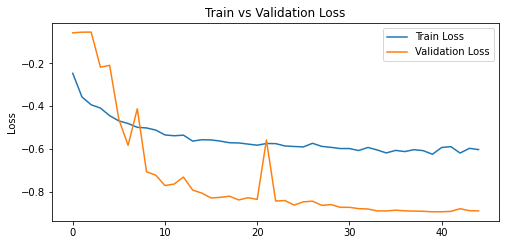

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.show()

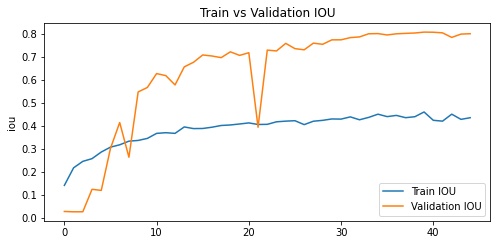

In [ ]:
iou = history.history['iou']
val_iou = history.history['val_iou']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(iou, label='Train IOU')
plt.plot(val_iou, label='Validation IOU')
plt.legend(loc='lower right')
plt.ylabel('iou')
plt.title('Train vs Validation IOU')
plt.show()

### Generating the Segmentation & Prediction Maps

In [ ]:
dependencies = {
    'dice_coef_loss':dice_coef_loss,
    'iou':iou   
}

In [ ]:
best_model = load_model('/content/gdrive/My Drive/brain_mri/segmentation/unet_epochs:040-val_iou:0.807.h5', 
                        custom_objects=dependencies)

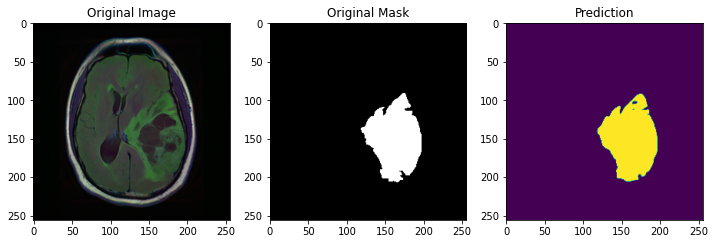

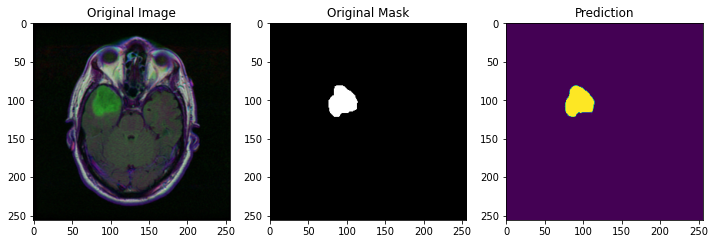

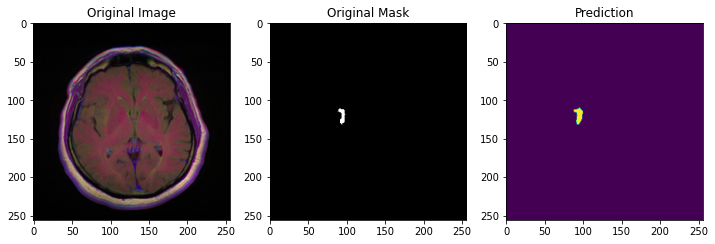

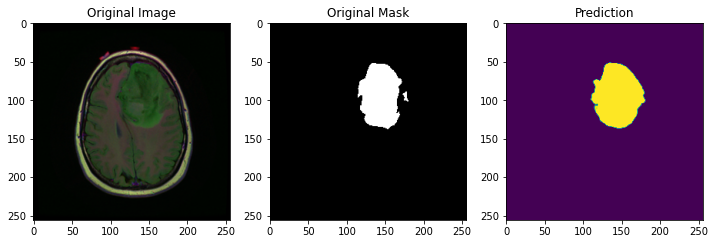

In [ ]:
for i in range(4):
    index=np.random.randint(1,len(test_df.index))    
    image = tf.io.read_file(test_df['images'].iloc[index]) #reads the image from the file path 
    image = tfio.experimental.image.decode_tiff(image)  #decodes the tiff file
    # image = tf.image.convert_image_dtype(image, tf.float32) #converts the float values in [0 1] interval 
    image = tf.image.resize(image, [256, 256]) # resizes the image
    img = image / 255
    img = img[np.newaxis, :, :, :]
    pred=best_model.predict(img)    

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))    
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(test_df['masks'].iloc[index])))    
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred))    
    plt.title('Prediction')
    plt.show()

## UNet++

In [ ]:
# https://github.com/1044197988/TF.Keras-Commonly-used-models/blob/master/%E5%B8%B8%E7%94%A8%E5%88%86%E5%89%B2%E6%A8%A1%E5%9E%8B/Unet_family/Unet_family.py

class conv_block_nested(models.Model):

    def __init__(self, mid_ch, out_ch):
        super(conv_block_nested, self).__init__()
        self.activation = layers.Activation('relu')
        self.conv1 = layers.Conv2D(mid_ch, kernel_size=3, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(out_ch, kernel_size=3, padding='same')
        self.bn2 = layers.BatchNormalization()

    def call(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)

        x = self.conv2(x)
        x = self.bn2(x)
        output = self.activation(x)

        return output

class NestedUNet(models.Model):
    """
    Implementation of this paper:
    https://arxiv.org/pdf/1807.10165.pdf
    """

    def __init__(self, classes=1):
        super(NestedUNet, self).__init__()

        n1 = 32
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.pool = layers.MaxPooling2D(strides=2)
        self.Up = layers.UpSampling2D()

        self.conv0_0 = conv_block_nested(filters[0], filters[0])
        self.conv1_0 = conv_block_nested(filters[1], filters[1])
        self.conv2_0 = conv_block_nested(filters[2], filters[2])
        self.conv3_0 = conv_block_nested(filters[3], filters[3])
        self.conv4_0 = conv_block_nested(filters[4], filters[4])

        self.conv0_1 = conv_block_nested(filters[0], filters[0])
        self.conv1_1 = conv_block_nested(filters[1], filters[1])
        self.conv2_1 = conv_block_nested(filters[2], filters[2])
        self.conv3_1 = conv_block_nested(filters[3], filters[3])

        self.conv0_2 = conv_block_nested(filters[0], filters[0])
        self.conv1_2 = conv_block_nested(filters[1], filters[1])
        self.conv2_2 = conv_block_nested(filters[2], filters[2])

        self.conv0_3 = conv_block_nested(filters[0], filters[0])
        self.conv1_3 = conv_block_nested(filters[1], filters[1])

        self.conv0_4 = conv_block_nested(filters[0], filters[0])

        self.final = layers.Conv2D(classes, kernel_size=1,activation='sigmoid',name='final_layer')

    def call(self, x):
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(layers.Concatenate()([x0_0, self.Up(x1_0)]))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(layers.Concatenate()([x1_0, self.Up(x2_0)]))
        x0_2 = self.conv0_2(layers.Concatenate()([x0_0, x0_1, self.Up(x1_1)]))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(layers.Concatenate()([x2_0, self.Up(x3_0)]))
        x1_2 = self.conv1_2(layers.Concatenate()([x1_0, x1_1, self.Up(x2_1)]))
        x0_3 = self.conv0_3(layers.Concatenate()([x0_0, x0_1, x0_2, self.Up(x1_2)]))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(layers.Concatenate()([x3_0, self.Up(x4_0)]))
        x2_2 = self.conv2_2(layers.Concatenate()([x2_0, x2_1, self.Up(x3_1)]))
        x1_3 = self.conv1_3(layers.Concatenate()([x1_0, x1_1, x1_2, self.Up(x2_2)]))
        x0_4 = self.conv0_4(layers.Concatenate()([x0_0, x0_1, x0_2, x0_3, self.Up(x1_3)]))

        output = self.final(x0_4)

        return output

In [ ]:
model = NestedUNet()
model.build((None,256,256,4))    
model.summary()

Model: "nested_u_net_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 multiple                  0         
_________________________________________________________________
conv_block_nested_30 (conv_b multiple                  10688     
_________________________________________________________________
conv_block_nested_31 (conv_b multiple                  55936     
_________________________________________________________________
conv_block_nested_32 (conv_b multiple                  222464    
_________________________________________________________________
conv_block_nested_33 (conv_b multiple                  887296    
_________________________________________________________________
conv_block_nested_34 (conv_b multiple               

#### Model Training

In [ ]:
EPOCHS = 150
learning_rate = 1e-4

In [ ]:
decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt,  loss=dice_coef_loss, metrics=["accuracy", iou])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [ ]:
filepath = "/content/gdrive/My Drive/brain_mri/segmentation/unet_plus/unet_plus_epochs:{epoch:03d}-val_iou:{val_iou:.3f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, verbose=1)

In [ ]:
log_dir = "/content/gdrive/My Drive/brain_mri/segmentation/unet_plus/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, profile_batch=0)

In [ ]:
callback_list = [early_stopping, checkpoint, tensorboard]

In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(train_dataset, epochs=100, validation_data=test_dataset, callbacks=callback_list)

Epoch 1/100
68/68 [==============================] - ETA: 0s - loss: -0.1928 - accuracy: 0.4231 - iou: 0.1073WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0096s vs `on_test_batch_end` time: 0.2643s). Check your callbacks.

Epoch 00001: val_loss improved from inf to -0.05714, saving model to /content/gdrive/My Drive/brain_mri/segmentation/unet_plus/unet_plus_epochs:001-val_iou:0.030.h5
68/68 [==============================] - 75s 1s/step - loss: -0.1928 - accuracy: 0.4231 - iou: 0.1073 - val_loss: -0.0571 - val_accuracy: 0.9704 - val_iou: 0.0296
Epoch 2/100
68/68 [==============================] - ETA: 0s - loss: -0.2517 - accuracy: 0.4638 - iou: 0.1446
Epoch 00002: val_loss improved from -0.05714 to -0.06184, saving model to /content/gdrive/My Drive/brain_mri/segmentation/unet_plus/unet_plus_epochs:002-val_iou:0.032.h5
68/68 [==============================] - 74s 1s/step - loss: -0.2517 - accuracy: 0.4638 - iou: 0.1446 - val_l

### Plotting the Train & Validation Scores

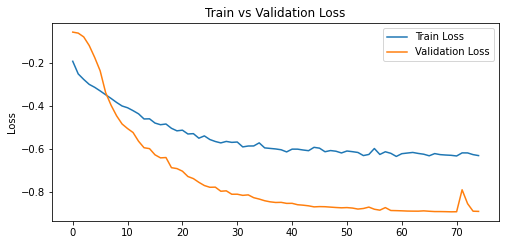

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.show()

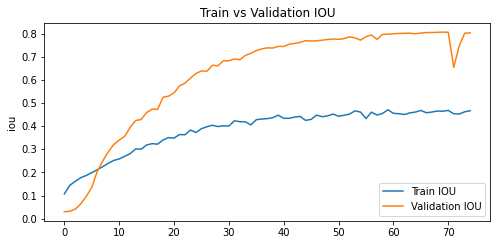

In [ ]:
iou = history.history['iou']
val_iou = history.history['val_iou']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(iou, label='Train IOU')
plt.plot(val_iou, label='Validation IOU')
plt.legend(loc='lower right')
plt.ylabel('iou')
plt.title('Train vs Validation IOU')
plt.show()

### Generating the Segmentation & Prediction Maps

In [ ]:
best_model = NestedUNet()
best_model.build((None,256,256,4)) 
best_model.load_weights('/content/gdrive/My Drive/brain_mri/segmentation/unet_plus/unet_plus_epochs:070-val_iou:0.808.h5')

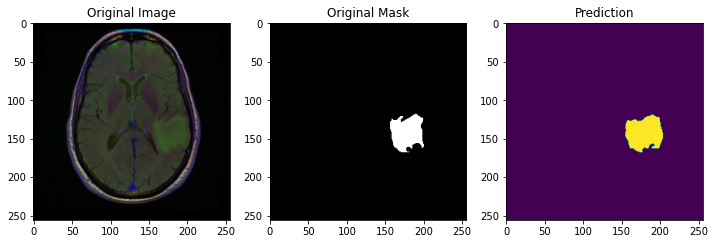

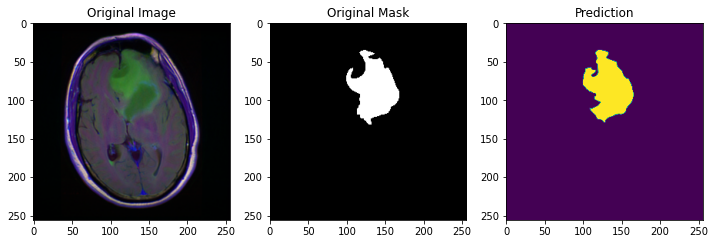

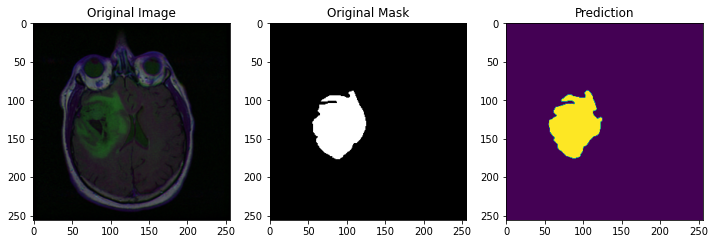

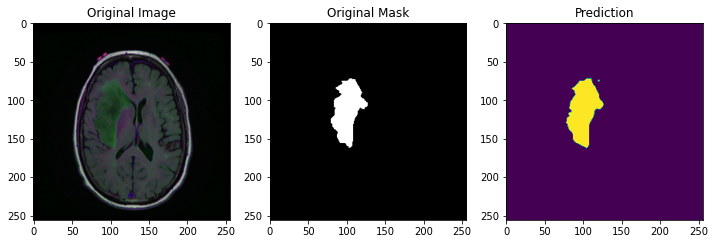

In [ ]:
for i in range(4):
    index=np.random.randint(1,len(test_df.index))    
    image = tf.io.read_file(test_df['images'].iloc[index]) #reads the image from the file path 
    image = tfio.experimental.image.decode_tiff(image)  #decodes the tiff file
    # image = tf.image.convert_image_dtype(image, tf.float32) #converts the float values in [0 1] interval 
    image = tf.image.resize(image, [256, 256]) # resizes the image
    img = image / 255
    img = img[np.newaxis, :, :, :]
    pred=best_model.predict(img)    

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))    
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(test_df['masks'].iloc[index])))    
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred))    
    plt.title('Prediction')
    plt.show()

## Prediction in terms of Probabilities for UNet & UNet++

In [ ]:
unet_model = load_model('/content/gdrive/My Drive/brain_mri/segmentation/unet_epochs:040-val_iou:0.807.h5', 
                        custom_objects=dependencies)

In [ ]:
nested_unet_model = NestedUNet()
nested_unet_model.build((None,256,256,4)) 
nested_unet_model.load_weights('/content/gdrive/My Drive/brain_mri/segmentation/unet_plus/unet_plus_epochs:070-val_iou:0.808.h5')

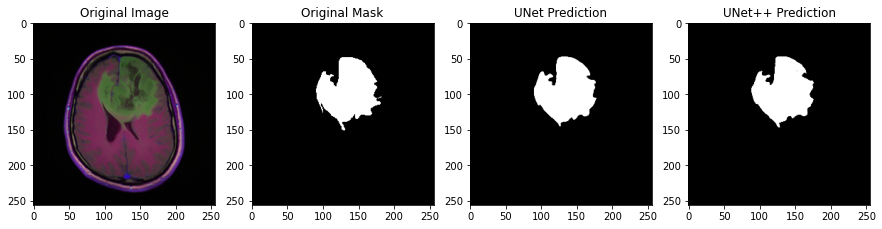

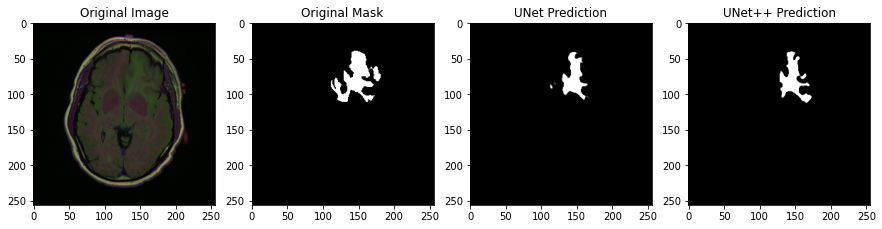

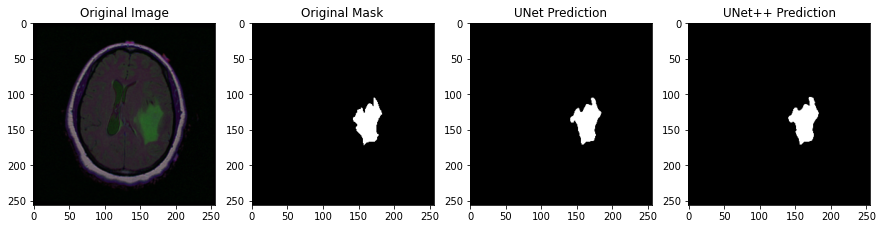

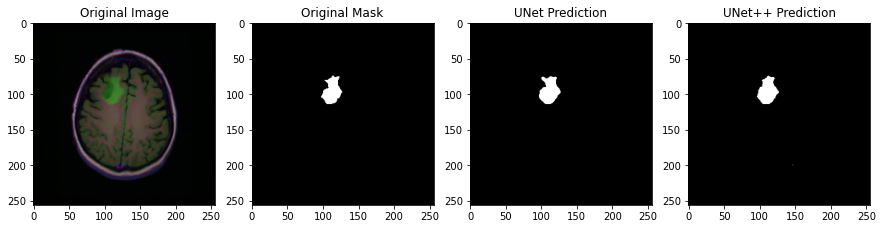

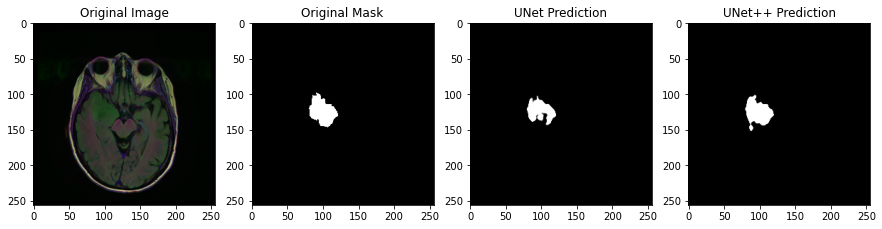

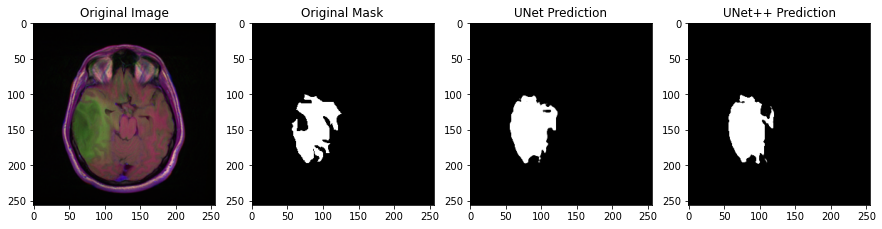

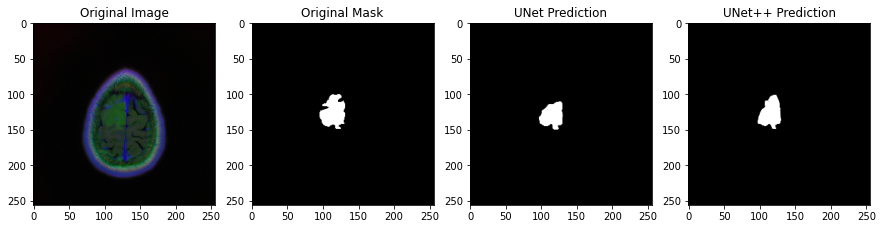

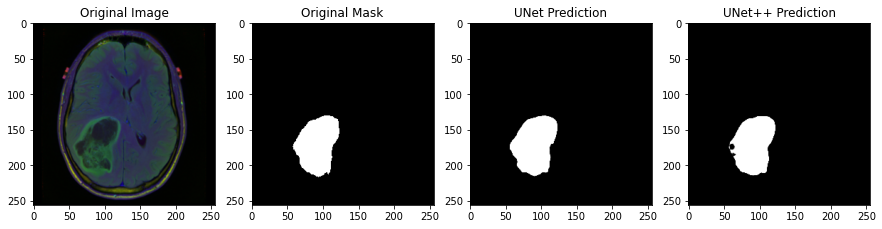

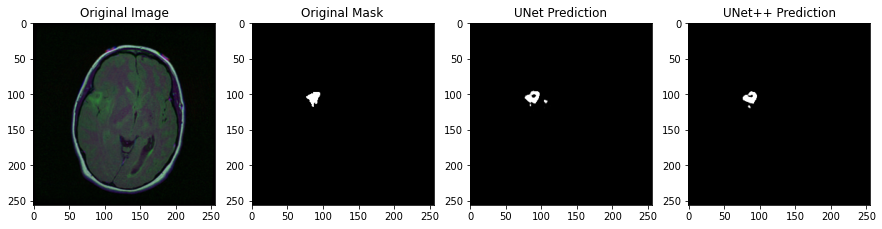

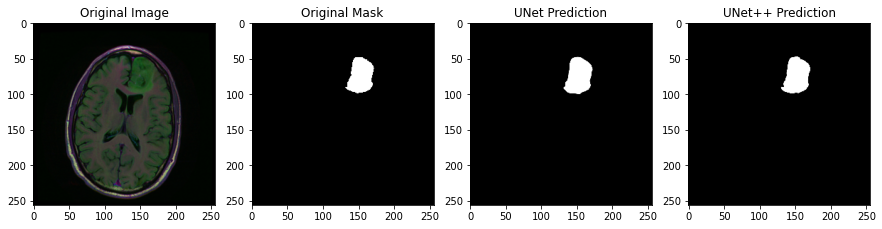

In [ ]:
for i in range(10):
    index=np.random.randint(1,len(test_df.index))    
    image = tf.io.read_file(test_df['images'].iloc[index]) #reads the image from the file path 
    image = tfio.experimental.image.decode_tiff(image)  #decodes the tiff file
    # image = tf.image.convert_image_dtype(image, tf.float32) #converts the float values in [0 1] interval 
    image = tf.image.resize(image, [256, 256]) # resizes the image
    img = image / 255
    img = img[np.newaxis, :, :, :]
    unet_pred = unet_model(img)  
    nested_unet_pred = nested_unet_model(img) 

    plt.figure(figsize=(15,15))
    plt.subplot(1,4,1)
    plt.imshow(np.squeeze(img))    
    plt.title('Original Image')
    plt.subplot(1,4,2)
    plt.imshow(np.squeeze(cv2.imread(test_df['masks'].iloc[index])))    
    plt.title('Original Mask')
    plt.subplot(1,4,3)
    plt.imshow(np.squeeze(unet_pred), cmap='gray')    
    plt.title('UNet Prediction')
    plt.subplot(1,4,4)
    plt.imshow(np.squeeze(nested_unet_pred), cmap='gray')    
    plt.title('UNet++ Prediction')
    plt.show()